In [2]:
import pandas as pd
import os
from os.path import join
import numpy as np
import mne
from mne_bids import (
    BIDSPath,
    read_raw_bids,
    print_dir_tree,
    make_report,
    find_matching_paths,
    get_entity_vals,
)

import h5py
from os.path import join as opj
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import tqdm
#from versatile_diffusion_dual_guided_fake_images import *

# from torchsummary import summary

import pandas as pd
import os
from os.path import join as opj
from PIL import Image
import h5py
import numpy as np
import nibabel as nib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

#import labelencoder
from sklearn.preprocessing import LabelEncoder
#import pipeline
from sklearn.pipeline import Pipeline
import tqdm
import torchvision

In [3]:
class NSDDataset(Dataset):

    
    def __init__(self, fmri_data,imgs_data,caption_data,transforms=None):
        self.fmri_data=np.load(fmri_data)
        self.imgs_data=np.load(imgs_data).astype(np.uint8)
        self.caption_data=np.load(caption_data,allow_pickle=True)
        self.transforms=transforms
        
    def __len__(self):
        return  len(self.fmri_data)
    
    def __getitem__(self,idx):
        fmri=torch.tensor(self.fmri_data[idx])
        img=Image.fromarray(self.imgs_data[idx])
        
        if self.transforms:
            img=self.transforms(img)
        
        caption=self.caption_data[idx][0] #cambiare se ne voglio altre
        
        return fmri,img,caption
                       

In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch
import torchvision
from torch.utils.data import DataLoader
import tqdm

device = "cuda:6"
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


In [5]:
torch.set_num_threads(64) 

In [5]:
def get_dataset(sub):
    base_path = "/srv/nfs-data/sisko/storage/fMRI_NSD/data"
    timeseries_path = opj(base_path, "nsddata_timeseries")
    betas_path = opj(base_path, "nsddata_betas")
    stimuli_path = opj(base_path, "nsddata_stimuli", "stimuli", "nsd")
    stim_file_path = opj(stimuli_path, "nsd_stimuli.hdf5")
    mod = "func1pt8mm"
    subj_data_path = opj(timeseries_path, "ppdata", sub, mod, "timeseries")
    subj_betas_path = opj(betas_path, "ppdata", sub, mod, "betas_assumehrf")
    subj_betas_roi_extracted_path = opj(base_path, "processed_roi", sub, mod)

    stim_order_path = opj(base_path, "nsddata", "experiments", "nsd", "nsd_expdesign.mat")
    stim_info_path = opj(base_path, "nsddata", "experiments", "nsd", "nsd_stim_info_merged.csv")
    stim_captions_train_path = opj(base_path, "nsddata_stimuli", "stimuli", "nsd", "annotations", f"captions_train2017.json")
    stim_captions_val_path = opj(base_path, "nsddata_stimuli", "stimuli", "nsd", "annotations", f"captions_val2017.json")

    processed_data = opj(base_path, "processed_data", sub)

    sub_idx = int(sub.split("0")[-1])

    fmri_train_data = opj(processed_data, f"nsd_train_fmriavg_nsdgeneral_sub{sub_idx}.npy")
    imgs_train_data = opj(processed_data, f"nsd_train_stim_sub{sub_idx}.npy")
    captions_train_data = opj(processed_data, f"nsd_train_cap_sub{sub_idx}.npy")

    fmri_test_data = opj(processed_data, f"nsd_test_fmriavg_nsdgeneral_sub{sub_idx}.npy")
    imgs_test_data = opj(processed_data, f"nsd_test_stim_sub{sub_idx}.npy")
    captions_test_data = opj(processed_data, f"nsd_test_cap_sub{sub_idx}.npy")

    tr = torchvision.transforms.ToTensor()
    train_dataset = NSDDataset(fmri_train_data, imgs_train_data, captions_train_data, transforms=tr)
    test_dataset = NSDDataset(fmri_test_data, imgs_test_data, captions_test_data, transforms=tr)

    BS = 32
    train_dataloader = DataLoader(train_dataset, BS, shuffle=False)
    test_dataloader = DataLoader(test_dataset, BS, shuffle=False)

    to_pil = torchvision.transforms.ToPILImage()

    train_clip_img_embeds = []
    train_fmri_data = []
    train_imgs = []

    with torch.no_grad():
        for x, y, c in tqdm.tqdm(train_dataloader, position=0):
            # Converti le tensori delle immagini in formato PIL
            images = [to_pil(i) for i in y]
            # Estrai le feature da CLIP
            image_features_batch = []
            for image in images:
                inputs = clip_processor(images=image, return_tensors="pt", padding=True).to(device)
                outputs = clip_model.get_image_features(**inputs)
                image_features_batch.append(outputs)  

            image_features_batch = torch.stack(image_features_batch, axis=0)  
            train_clip_img_embeds.append(image_features_batch)
            train_fmri_data.append(x)
            train_imgs.append(y)

        train_clip_img_embeds = torch.cat(train_clip_img_embeds, axis=0)
        train_fmri_data = torch.cat(train_fmri_data, 0)
        train_imgs = torch.cat(train_imgs, 0)

    test_clip_img_embeds = []
    test_fmri_data = []
    test_imgs = []

    with torch.no_grad():
        for x, y, c in tqdm.tqdm(test_dataloader, position=0):
            # Converti le tensori delle immagini in formato PIL
            images = [to_pil(i) for i in y]
            # Estrai le feature da CLIP
            image_features_batch = []
            for image in images:
                inputs = clip_processor(images=image, return_tensors="pt", padding=True).to(device)
                outputs = clip_model.get_image_features(**inputs)
                image_features_batch.append(outputs)  

            image_features_batch = torch.stack(image_features_batch, axis=0) 
            test_clip_img_embeds.append(image_features_batch)
            test_fmri_data.append(x)
            test_imgs.append(y)

        test_clip_img_embeds = torch.cat(test_clip_img_embeds, axis=0)
        test_fmri_data = torch.cat(test_fmri_data, 0)
        test_imgs = torch.cat(test_imgs, 0)

    # Standardizza i dati
    mean = train_fmri_data.mean(0)
    std = train_fmri_data.std(0)
    train_fmri_data = (train_fmri_data - mean) / std
    test_fmri_data = (test_fmri_data - mean) / std

    test_fmri_data = torch.nan_to_num(test_fmri_data)
    train_fmri_data = torch.nan_to_num(train_fmri_data)

    return train_fmri_data, test_fmri_data, train_imgs, test_imgs, train_clip_img_embeds, test_clip_img_embeds


In [6]:
def get_dataset(sub):
    base_path="/srv/nfs-data/sisko/storage/fMRI_NSD/data"
    timeseries_path=opj(base_path,"nsddata_timeseries")
    betas_path=opj(base_path,"nsddata_betas")

    stimuli_path=opj(base_path,"nsddata_stimuli","stimuli","nsd")
    stim_file_path=opj(stimuli_path,"nsd_stimuli.hdf5")
    mod="func1pt8mm"
    subj_data_path=opj(timeseries_path,"ppdata",sub,mod,"timeseries")
    subj_betas_path=opj(betas_path,"ppdata",sub,mod,"betas_assumehrf")

    subj_betas_roi_extracted_path=opj(base_path,"processed_roi",sub,mod)

    stim_order_path=opj(base_path,"nsddata","experiments","nsd","nsd_expdesign.mat")
    stim_info_path=opj(base_path,"nsddata","experiments","nsd","nsd_stim_info_merged.csv")
    stim_captions_train_path=opj(base_path,"nsddata_stimuli","stimuli","nsd","annotations",f"captions_train2017.json")
    stim_captions_val_path=opj(base_path,"nsddata_stimuli","stimuli","nsd","annotations",f"captions_val2017.json")

    processed_data=opj(base_path,"processed_data",sub)

    sub_idx=int(sub.split("0")[-1])

    fmri_train_data=opj(processed_data,f"nsd_train_fmriavg_nsdgeneral_sub{sub_idx}.npy")
    imgs_train_data=opj(processed_data,f"nsd_train_stim_sub{sub_idx}.npy")
    captions_train_data=opj(processed_data, f"nsd_train_cap_sub{sub_idx}.npy")

    fmri_test_data=opj(processed_data,f"nsd_test_fmriavg_nsdgeneral_sub{sub_idx}.npy")
    imgs_test_data=opj(processed_data,f"nsd_test_stim_sub{sub_idx}.npy")
    captions_test_data=opj(processed_data, f"nsd_test_cap_sub{sub_idx}.npy")



    tr=torchvision.transforms.ToTensor()
    train_dataset=NSDDataset(fmri_train_data,imgs_train_data,captions_train_data,transforms=tr)
    test_dataset=NSDDataset(fmri_test_data,imgs_test_data,captions_test_data,transforms=tr)


    BS=32

    train_dataloader=DataLoader(train_dataset,BS,shuffle=False)
    # val_dataloader=DataLoader(val_dataset,BS,shuffle=True)
    test_dataloader=DataLoader(test_dataset,BS,shuffle=False)



    to_pil= torchvision.transforms.ToPILImage()

    train_clip_img_embeds=[]
    train_fmri_data=[]
    train_imgs=[]
    with torch.no_grad():
        for x, y, c in tqdm.tqdm(train_dataloader, position=0):
            # Save img data
            images = [to_pil(i) for i in y]
            # Process images one by one
            image_features_batch = []
            for image in images:
                image_features = pipeline.prepare_ip_adapter_image_embeds(
                    ip_adapter_image=image,
                    ip_adapter_image_embeds=None,
                    device="cuda:7",
                    num_images_per_prompt=1,
                    do_classifier_free_guidance=True,
                )
                image_features_batch.append(image_features[0])  # Append the tensor directly
            image_features_batch = torch.stack(image_features_batch, axis=0)  # Use stack instead of cat
            
            train_clip_img_embeds.append(image_features_batch)
            train_fmri_data.append(x)
            train_imgs.append(y)

        train_clip_img_embeds = torch.cat(train_clip_img_embeds, axis=0)
        train_fmri_data = torch.cat(train_fmri_data, 0)
        train_imgs = torch.cat(train_imgs, 0)

    test_clip_img_embeds = []
    test_fmri_data = []
    test_imgs = []

    with torch.no_grad():
        for x, y, c in tqdm.tqdm(test_dataloader, position=0):
            # Save img data
            images = [to_pil(i) for i in y]
            # Process images one by one
            image_features_batch = []
            for image in images:
                image_features = pipeline.prepare_ip_adapter_image_embeds(
                    ip_adapter_image=image,
                    ip_adapter_image_embeds=None,
                    device="cuda:7",
                    num_images_per_prompt=1,
                    do_classifier_free_guidance=True,
                )
                image_features_batch.append(image_features[0])  # Append the tensor directly
            image_features_batch = torch.stack(image_features_batch, axis=0)  # Use stack instead of cat
            
            test_clip_img_embeds.append(image_features_batch)
            test_fmri_data.append(x)
            test_imgs.append(y)

        test_clip_img_embeds = torch.cat(test_clip_img_embeds, axis=0)
        test_fmri_data = torch.cat(test_fmri_data, 0)
        test_imgs = torch.cat(test_imgs, 0)

    # Standardize data
    mean = train_fmri_data.mean(0)
    std = train_fmri_data.std(0)
    train_fmri_data = (train_fmri_data - mean) / std
    test_fmri_data = (test_fmri_data - mean) / std

    test_fmri_data = torch.nan_to_num(test_fmri_data)
    train_fmri_data = torch.nan_to_num(train_fmri_data)

    return train_fmri_data, test_fmri_data, train_imgs, test_imgs, train_clip_img_embeds, test_clip_img_embeds


In [6]:
train_datas=[]
test_datas=[]
img_train=[]
img_test=[]
train_clip_img_embeds=[]
test_clip_img_embeds=[]
subject_train_ids=[]
subject_test_ids=[]

for p in tqdm.tqdm(["subj01","subj02","subj05","subj07"]):
    train_data_,test_data_, img_train_, img_test_,train_clip_img_embeds_, test_clip_img_embeds_=get_dataset(p)
    img_train.append(img_train_)
    img_test.append(img_test_)
    train_datas.append(train_data_)
    test_datas.append(test_data_)
    train_clip_img_embeds.append(train_clip_img_embeds_)
    test_clip_img_embeds.append(test_clip_img_embeds_)

    subject_train_ids+=[p]*len(train_data_)
    subject_test_ids+=[p]*len(test_data_)


print("train data shape",train_datas[0].shape)
print("test data shape",test_datas[0].shape)
print("img shape",img_train[0].shape)
print("imgtest shape",img_test[0].shape)
print("train_emb shape",train_clip_img_embeds[0].shape)
print("test emb shape",test_clip_img_embeds[0].shape)

100%|██████████| 4/4 [39:18<00:00, 589.54s/it]

train data shape torch.Size([8859, 15724])
test data shape torch.Size([982, 15724])
img shape torch.Size([8859, 3, 425, 425])
imgtest shape torch.Size([982, 3, 425, 425])
train_emb shape torch.Size([8859, 1, 512])
test emb shape torch.Size([982, 1, 512])


In [ ]:
max_cols = max(array.shape[1] for array in train_datas)
padded_train_datas = []
for array in train_datas:
    # Calculate padding needed for rows and columns
    pad_cols = max_cols - array.shape[1]

    # Apply padding (adding zeros)
    padded_array = np.pad(array, ((0, 0), (0, pad_cols)), mode='constant', constant_values=0)
    padded_train_datas.append(padded_array)

    
padded_test_datas = []
for array in test_datas:
    # Calculate padding needed for rows and columns
    pad_cols = max_cols - array.shape[1]

    # Apply padding (adding zeros)
    padded_array = np.pad(array, ((0, 0), (0, pad_cols)), mode='constant', constant_values=0)
    padded_test_datas.append(padded_array)


print("padded_train_datas shape",padded_train_datas[0].shape)
print("padded_test_datas shape",padded_test_datas[0].shape)


train_data=np.concatenate(padded_train_datas,0)
test_data=np.concatenate(padded_test_datas,0)

img_train=torch.cat(img_train,0)
img_test=torch.cat(img_test,0)

train_clip_img_embeds=torch.cat(train_clip_img_embeds,0)
test_clip_img_embeds=torch.cat(test_clip_img_embeds,0)


print("train_data shape", train_data.shape)
print("test_data shape",test_data.shape)
print("img_train shape",img_train.shape)
print("img_test shape",img_test.shape)
print("train_clip_img_embeds shape",train_clip_img_embeds.shape)
print("test_clip_img_embeds shape",test_clip_img_embeds.shape)


padded_train_datas shape (8859, 15724)
padded_test_datas shape (982, 15724)
train_data shape (35436, 15724)
test_data shape (3928, 15724)
img_train shape torch.Size([35436, 3, 425, 425])
img_test shape torch.Size([3928, 3, 425, 425])
train_clip_img_embeds shape torch.Size([35436, 1, 512])
test_clip_img_embedsshape torch.Size([3928, 1, 512])


In [ ]:
dest_path = "*"
os.makedirs(dest_path,exist_ok=True)

#save everything

np.save(os.path.join(dest_path, "train_data.npy"), train_data)
np.save(os.path.join(dest_path, "test_data.npy"), test_data)

torch.save(train_clip_img_embeds, os.path.join(dest_path, "train_clip_img_embeds.pt"))
torch.save(test_clip_img_embeds, os.path.join(dest_path, "test_clip_img_embeds.pt"))

torch.save(img_train, os.path.join(dest_path, "img_train.pt"))
torch.save(img_test, os.path.join(dest_path, "img_test.pt"))

np.save(os.path.join(dest_path, "subject_train_ids.npy"), np.array(subject_train_ids))
np.save(os.path.join(dest_path, "subject_test_ids.npy"), np.array(subject_test_ids))

## Start from here, loading data

In [ ]:
dest_path = "*"
os.makedirs(dest_path,exist_ok=True)


In [7]:
train_data = np.load(f"{dest_path}/train_data.npy")
test_data = np.load(f"{dest_path}/test_data.npy")

train_clip_img_embeds = torch.load(f"{dest_path}/train_clip_img_embeds.pt")
test_clip_img_embeds = torch.load(f"{dest_path}/test_clip_img_embeds.pt")

img_train = torch.load(f"{dest_path}/img_train.pt")
img_test = torch.load(f"{dest_path}/img_test.pt")

# train_captions = torch.load(f"{dest_path}/train_captions.pt")
# test_captions = torch.load(f"{dest_path}/test_captions.pt")

subject_train_ids = np.load(f"{dest_path}/subject_train_ids.npy")
subject_test_ids = np.load(f"{dest_path}/subject_test_ids.npy")

/tmp/ipykernel_4158545/62682910.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_clip_img_embeds = torch.load(f"{dest_path}/train_clip_img_embeds.pt")
/tmp/ipykerne

In [8]:
subject_train_ids

array(['subj01', 'subj01', 'subj01', ..., 'subj07', 'subj07', 'subj07'],
      dtype='<U6')

In [9]:
# Verify the loaded data
train_data.shape, test_data.shape, train_clip_img_embeds.shape, test_clip_img_embeds.shape, img_train.shape, img_test.shape, subject_train_ids.shape, subject_test_ids.shape

((35436, 15724),
 (3928, 15724),
 torch.Size([35436, 1, 512]),
 torch.Size([3928, 1, 512]),
 torch.Size([35436, 3, 425, 425]),
 torch.Size([3928, 3, 425, 425]),
 (35436,),
 (3928,))

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim,act_fn=nn.ReLU,alignment_layers_keys=[1,2,5,7],common_dim=1024):
        super(Encoder, self).__init__()
        self.common_dim=common_dim
        self.alignment_layers={}
        for k in alignment_layers_keys:
            self.alignment_layers[k]=nn.Linear(input_dim, common_dim)      # Lazy
        
        layers = []
        prev_dim = input_dim
        layers.append(nn.LayerNorm(common_dim))
        if len(hidden_dims):

            for hidden_dim in hidden_dims:
                layers.append(nn.Linear(common_dim, hidden_dim))
                layers.append(act_fn())     # TODO: mettere identity
            layers.append(nn.Linear(hidden_dim, output_dim))
           
        else:
            layers.append(nn.Linear(common_dim, output_dim))
        self.net = nn.Sequential(*layers)   

        
    def _apply(self, fn):
        super(Encoder, self)._apply(fn)        
        for k,v in self.alignment_layers.items():
            self.alignment_layers[k]._apply(fn)
            
    
    def forward(self, x, k=None):
        
        def apply_alignment_layers(x, k, alignment_layers):
            # Create an empty tensor to store the results
            result = torch.empty_like(x)
            result = result[:,:self.common_dim]
            
            # Iterate through each unique key in k
            for key in k.unique():
                # Create a mask for all elements that match the current key
                mask = (k == key.item())
                
                # Apply the corresponding alignment layer to the masked elements
                result[mask] = alignment_layers[key.item()](x[mask])
            
            return result
        
        if k is None:
            k=torch.ones(len(x))
        # Apply alignment layers to x using the custom function
        x = apply_alignment_layers(x, k, self.alignment_layers)
        # x = self.alignment_layers[k](x)
        return self.net(x)





In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

# Funzione per calcolare la similarità coseno
def cosine_similarity_matrix(A, B):
    A_norm = F.normalize(A, dim=1)
    B_norm = F.normalize(B, dim=1)
    return torch.mm(A_norm, B_norm.T)

# NT-Xent Loss (Contrastive)
def contrastive_loss_nt(S, tau):
    S_exp = torch.exp(S / tau)
    loss = -torch.log(torch.diag(S_exp) / S_exp.sum(dim=1))
    return loss.mean()

def contrastive_loss(z_i, z_j, tau):
    z_i = nn.functional.normalize(z_i, dim=1)
    z_j = nn.functional.normalize(z_j, dim=1)
    logits = (z_i @ z_j.T) / tau
    similarities = z_j @ z_j.T
    # targets = torch.nn.functional.softmax(similarities * self.temperature, dim=-1)
    targets = torch.arange(logits.shape[0]).long().to(logits.device)
    loss = torch.nn.functional.cross_entropy(logits, targets)
    return loss


tau = 0.02   

class ContrastiveOTModel(pl.LightningModule):
    def __init__(self, input_dim, hidden_dims, output_dim, common_dim=1024, alignment_layers_keys=[1,2,5,7]):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dims, output_dim, alignment_layers_keys=alignment_layers_keys, common_dim=common_dim) 
        self.tau = tau

        self.train_losses = []
        self.train_ot_loss=[]
        self.train_contrastive_loss=[]
        self.val_losses = []
        self.val_ot_loss=[]
        self.val_contrastive_loss=[]
    
        self.train_history={}
        self.val_history={}

        self.train_history["train_loss"]=[]
        self.train_history["train_ot_loss"]=[]
        self.train_history["train_contrastive_loss"]=[]
        self.val_history["val_loss"]=[]
        self.val_history["val_ot_loss"]=[]
        self.val_history["val_contrastive_loss"]=[]

    def forward(self, x, **kwargs):
        # x = self.encoder(x,**kwargs)
        # x = self.dropout(x)
        return self.encoder(x,**kwargs)

    def loss_fn(self, x_latent, y_latent):
        S = cosine_similarity_matrix(x_latent, y_latent)
        contrastive_loss_value = contrastive_loss_nt(S, self.tau) 
        total_loss = contrastive_loss_value
        return total_loss, contrastive_loss_value
    
    def compute_loss(self, x, y, idx):
        x_latent = self(x, k=idx)
        y_latent = y  
        return self.loss_fn(x_latent, y_latent)

    # def compute_loss(self, x, y, idx):
    #     x_latent = self(x, k=idx)
    #     y_latent = y
    #     cost_matrix = torch.cdist(x_latent, y_latent, p=2) ** 2  
    #     N = cost_matrix.shape[0]  
    #     M = cost_matrix.shape[1]  
    #     a = (lambda_ / N) * torch.ones(N, device=x.device)
    #     b = (lambda_ / M) * torch.ones(M, device=x.device)
    #     return self.loss_fn(x_latent, y_latent, cost_matrix, a, b)

    def training_step(self, batch, batch_idx):
        x, y, idx = batch  
        loss, contrastive_loss_value = self.compute_loss(x, y, idx)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("train_contrastive_loss", contrastive_loss_value, on_epoch=True)

        self.train_losses.append(loss.item())
        self.train_contrastive_loss.append(contrastive_loss_value.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, idx = batch
        loss, contrastive_loss_value = self.compute_loss(x, y, idx)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_contrastive_loss", contrastive_loss_value, on_epoch=True)

        self.val_losses.append(loss.item())
        self.val_contrastive_loss.append(contrastive_loss_value.item())
        return loss
    
    def on_train_epoch_end(self) -> None:
        self.train_history["train_loss"].append(np.mean(self.train_losses))
        self.train_history["train_contrastive_loss"].append(np.mean(self.train_contrastive_loss))
        self.train_losses = []
        self.train_contrastive_loss=[]
        return super().on_train_epoch_end()
    
    def on_validation_epoch_end(self) -> None:
        self.val_history["val_loss"].append(np.mean(self.val_losses))
        self.val_history["val_contrastive_loss"].append(np.mean(self.val_contrastive_loss))
        self.val_losses = []

        self.val_ot_loss=[]
        self.val_contrastive_loss=[]
        return super().on_validation_epoch_end()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4, weight_decay=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=10, threshold=0.05, verbose=True)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
    
    


In [13]:
subject_train_ids=[int(i[-1]) for i in subject_train_ids]
subject_test_ids=[int(i[-1]) for i in subject_test_ids]

In [14]:
train_data.shape, train_clip_img_embeds.shape, test_data.shape, test_clip_img_embeds.shape

((35436, 15724),
 torch.Size([35436, 1, 512]),
 (3928, 15724),
 torch.Size([3928, 1, 512]))

In [15]:
train_data.mean(), train_clip_img_embeds.mean(), train_data.std(), train_clip_img_embeds.std()

(2.73128019976236e-17,
 tensor(-0.0044, device='cuda:2'),
 0.9411984836072855,
 tensor(0.4607, device='cuda:2'))

In [16]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_data).float(),train_clip_img_embeds.squeeze(1).float(), torch.tensor(subject_train_ids))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_data).float(),test_clip_img_embeds.squeeze(1).float(), torch.tensor(subject_test_ids))

x,y,idx=train_dataset[0]  

# BS = len(train_dataset)  # 35436
# BS_test = len(test_dataset)  # 35436
BS = 2048 
BS_test = int(BS/4) 

# reduced_train_dataset = get_reduced_dataset(train_dataset, fraction=0.5)
# clip_train_dataloader = DataLoader(reduced_train_dataset, batch_size=BS, shuffle=True)
clip_train_dataloader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
clip_test_dataloader = DataLoader(test_dataset, batch_size=BS_test, shuffle=False)

x, y, idx = next(iter(clip_train_dataloader))
print(x.shape, y.shape)  # Dovrebbe stampare torch.Size([35436, 15724]) torch.Size([35436, 1280]) con intero batch


torch.Size([2048, 15724]) torch.Size([2048, 512])


In [ ]:
pl.seed_everything(42, workers=True)

# Configurazione PyTorch Lightning
brain_model = ContrastiveOTModel(input_dim=train_data.shape[-1], hidden_dims=[1024],
                                 output_dim=512, common_dim=15724, alignment_layers_keys=[1, 2, 5, 7])

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.09, patience=7, verbose=True, mode="min")
trainer = pl.Trainer(max_epochs=100, devices=[2], callbacks=[early_stop_callback])
trainer.fit(brain_model, clip_train_dataloader, clip_test_dataloader)


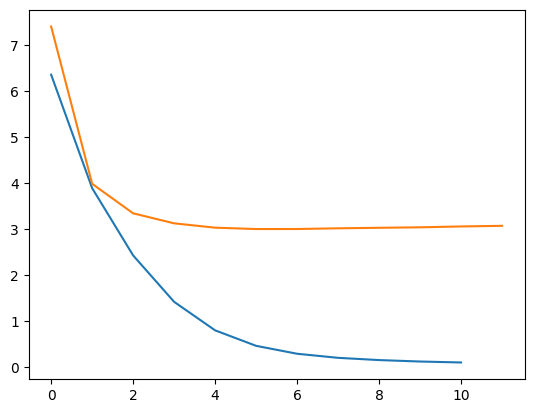

In [29]:
plt.plot(brain_model.train_history["train_loss"], label='train')
plt.plot(brain_model.val_history["val_loss"], label='val')

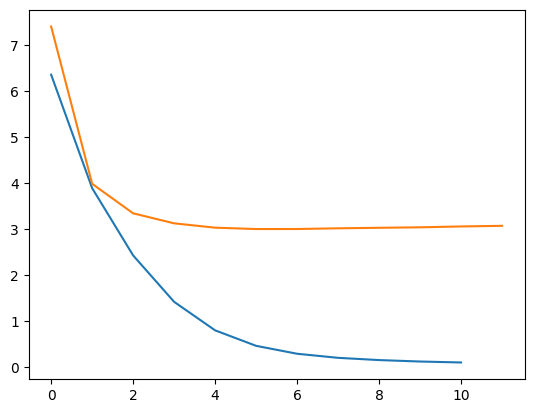

In [31]:
plt.plot(brain_model.train_history["train_contrastive_loss"], label='train')
plt.plot(brain_model.val_history["val_contrastive_loss"], label='val')

## Load trained models

In [ ]:
tgt_dir = "*"

In [ ]:
clone_model = ContrastiveOTModel(input_dim=train_data.shape[-1], hidden_dims=[1024],
                                 output_dim=512, common_dim=15724, alignment_layers_keys=[1, 2, 5, 7])

state_dict = torch.load(f"{tgt_dir}/whole_model_state_dict.pt")
encoder_state_dict = torch.load(f"{tgt_dir}/encoder_state_dict.pt")
clone_model.load_state_dict(state_dict)
clone_model.encoder.load_state_dict(encoder_state_dict)

for k in clone_model.encoder.alignment_layers.keys():
        alignment_layer_state_dict = torch.load(f"{tgt_dir}/alignment_layers_{k}_state_dict.pt")
        clone_model.encoder.alignment_layers[k].load_state_dict(alignment_layer_state_dict)




In [32]:
import tqdm as tqdm

x,y,k=next(iter(clip_test_dataloader))

y_pred=[]
y_true=[]
with torch.no_grad():
    for x,y,k in tqdm.tqdm(clip_test_dataloader):
        y_hat=brain_model(x,k=k).to(device)
        y_true.append(y)
        y_pred.append(y_hat)
y_pred=torch.cat(y_pred,0)
y_true=torch.cat(y_true,0)

100%|██████████| 8/8 [00:01<00:00,  6.79it/s]


In [33]:
y_pred.shape, y_true.shape

(torch.Size([3928, 512]), torch.Size([3928, 512]))

In [34]:
pc_after = []

for obs_idx in tqdm.trange(y_pred.shape[0]):
    pc_a = np.corrcoef(y_pred.cpu()[obs_idx], y_true.cpu()[obs_idx])[0,1]
    pc_after.append(pc_a)

print("Mean PC - OT:", np.array(pc_after).mean())

100%|██████████| 3928/3928 [00:03<00:00, 1167.98it/s]

Mean PC - OT: 0.19568644893532428


In [35]:
from sklearn.neighbors import NearestNeighbors

samples_per_subject = 982  
# subject_idx = 1
top1_count_list = []
top3_count_list = []

for subject_idx in range(4):
    start_idx = subject_idx * samples_per_subject
    end_idx = (subject_idx + 1) * samples_per_subject

    y_true_np = y_true[start_idx:end_idx].cpu().numpy()
    y_pred_np = y_pred[start_idx:end_idx].cpu().numpy()
    nbrs = NearestNeighbors(n_neighbors=3, metric='cosine').fit(y_true[0:samples_per_subject].cpu().numpy())

    distances, top_indices = nbrs.kneighbors(y_pred_np)
    true_indices = torch.arange(len(y_true_np)).cpu().numpy()

    # Calcoliamo il numero di volte in cui il candidato stimato è nella top-1 e top-3
    top1_count = (top_indices[:, 0] == true_indices).sum()
    top3_count = sum(true_idx in top_indices[i] for i, true_idx in enumerate(true_indices))

    print(f"Soggetto {subject_idx + 1}:")
    print(f"Top-1 accuracy: {top1_count}/{len(y_true_np)} ({top1_count / len(y_true_np) * 100:.2f}%)")
    print(f"Top-3 accuracy: {top3_count}/{len(y_true_np)} ({top3_count / len(y_true_np) * 100:.2f}%)")

    top1_count_list.append(top1_count)
    top3_count_list.append(top3_count)

print("---------------------------")
print("Top-1 accuracy:", sum(top1_count_list) / len(y_true) * 100)
print("Top-3 accuracy:", sum(top3_count_list) / len(y_true) * 100)

Soggetto 1:
Top-1 accuracy: 202/982 (20.57%)
Top-3 accuracy: 372/982 (37.88%)
Soggetto 2:
Top-1 accuracy: 148/982 (15.07%)
Top-3 accuracy: 308/982 (31.36%)
Soggetto 3:
Top-1 accuracy: 232/982 (23.63%)
Top-3 accuracy: 420/982 (42.77%)
Soggetto 4:
Top-1 accuracy: 121/982 (12.32%)
Top-3 accuracy: 289/982 (29.43%)
---------------------------
Top-1 accuracy: 17.897148676171078
Top-3 accuracy: 35.36150712830957


In [27]:
torch.save(y_pred, f"{tgt_dir}/y_pred_otcl.pt")

## Angles analysis

In [25]:
y_pred_best = y_pred

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Principal Angles & Bootstrap
# -----------------------------

def principal_angles(Y_true: np.ndarray, Y_pred: np.ndarray, r: int = 32) -> np.ndarray:
    """
    Angoli principali (in radianti) tra i sottospazi generati dai primi r PC di Y_true e Y_pred.
    Restituisce un array di lunghezza r con angoli in [0, pi/2].
    """
    # centra per colonna
    Yt = Y_true - Y_true.mean(axis=0, keepdims=True)
    Yp = Y_pred - Y_pred.mean(axis=0, keepdims=True)
    # PCA tramite SVD
    _, _, Vt_t = np.linalg.svd(Yt, full_matrices=False)  # Vt_t: [d, d]
    _, _, Vt_p = np.linalg.svd(Yp, full_matrices=False)
    Rt = Vt_t[:r, :].T  # [d, r]
    Rp = Vt_p[:r, :].T  # [d, r]
    # angoli principali via SVD di Rt^T Rp
    _, S, _ = np.linalg.svd(Rt.T @ Rp, full_matrices=False)
    S = np.clip(S, 0.0, 1.0)
    return np.arccos(S)  # [r], radianti

def compute_principal_angles_deg(y_true, y_pred_linear, y_pred_mlp, r=32):
    phi_lin = principal_angles(y_true, y_pred_linear, r=r)
    phi_mlp = principal_angles(y_true, y_pred_mlp, r=r)
    return np.degrees(phi_lin), np.degrees(phi_mlp)  # in gradi

def bootstrap_delta_mean(y_true, y_pred_linear, y_pred_mlp, r=32, B=1000, seed=0):
    """
    Bootstrap (resampling sui campioni) della differenza MLP-Linear sulla media degli angoli principali (in gradi).
    Restituisce: (delta_point, delta_boot, ci_low, ci_high, p_two_sided)
    """
    rng = np.random.default_rng(seed)
    n = y_true.shape[0]
    # punto: sull'intero set
    phi_lin_deg, phi_mlp_deg = compute_principal_angles_deg(y_true, y_pred_linear, y_pred_mlp, r=r)
    delta_point = float(phi_mlp_deg.mean() - phi_lin_deg.mean())
    # bootstrap
    deltas = []
    for _ in range(B):
        idx = rng.integers(0, n, size=n)  # resampling righe
        yt = y_true[idx]
        yl = y_pred_linear[idx]
        ym = y_pred_mlp[idx]
        pl, pm = compute_principal_angles_deg(yt, yl, ym, r=r)
        deltas.append(pm.mean() - pl.mean())
    deltas = np.array(deltas)
    ci_low, ci_high = np.percentile(deltas, [2.5, 97.5])
    # p-value bootstrap (two-sided): quanta massa è dall'altra parte dello zero
    p_two_sided = 2 * min((deltas <= 0).mean(), (deltas >= 0).mean())
    return delta_point, deltas, ci_low, ci_high, p_two_sided

# -----------------------------
# Plot utilities
# -----------------------------

def plot_per_component_angles(phi_lin_deg, phi_mlp_deg, title='Principal Angles per Component'):
    """
    Line plot degli angoli (in gradi) per ciascun componente (1..r) per Linear e MLP.
    """
    r = len(phi_lin_deg)
    x = np.arange(1, r+1)
    plt.figure()
    plt.plot(x, phi_lin_deg, marker='o', linestyle='-', label='Linear')
    plt.plot(x, phi_mlp_deg, marker='o', linestyle='-', label='MLP')
    plt.xlabel('Component index (top-r PC)')
    plt.ylabel('Principal angle (degrees)')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_bootstrap_hist(deltas, delta_point, ci_low, ci_high, title='Bootstrap Δ mean (MLP - Linear)'):
    """
    Istogramma della distribuzione bootstrap della differenza media (in gradi) con CI 95%.
    """
    plt.figure()
    plt.hist(deltas, bins=50, alpha=0.8)
    plt.axvline(delta_point, linestyle='--', label=f'Point est: {delta_point:.2f}°')
    plt.axvline(ci_low, linestyle=':', label=f'95% CI low: {ci_low:.2f}°')
    plt.axvline(ci_high, linestyle=':', label=f'95% CI high: {ci_high:.2f}°')
    plt.xlabel('Δ mean principal angle (deg)  [MLP - Linear]')
    plt.ylabel('Count')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

Mean principal angle (Linear): 49.011°
Mean principal angle (MLP)   : 53.967°
Delta (MLP - Linear)         : 4.956°


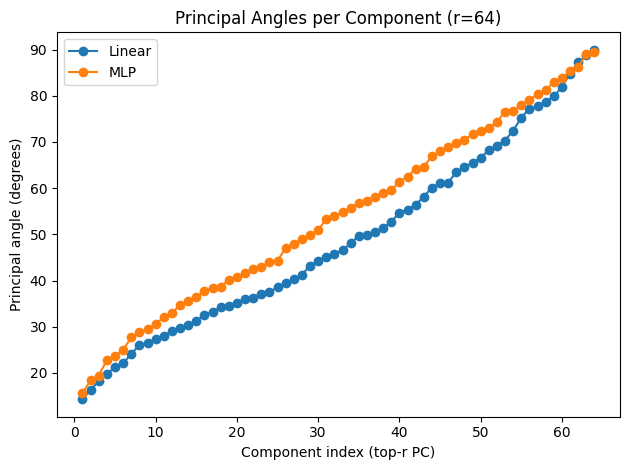


Bootstrap Δ mean (MLP - Linear): 4.956°
95% CI: [4.542°, 5.276°]
Bootstrap two-sided p ≈ 0.0000


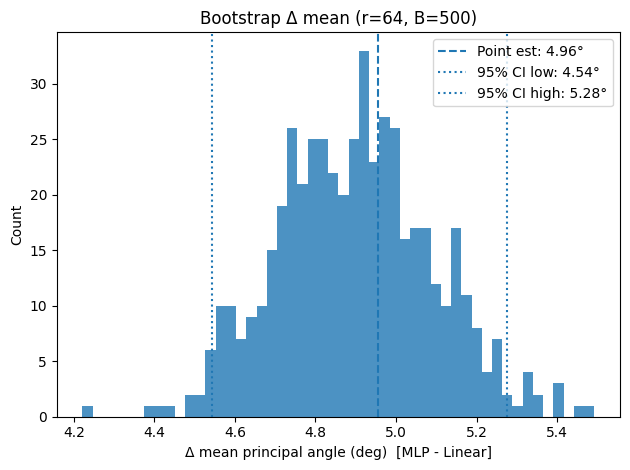

In [52]:
r = 64
B = 500

# 1) Angoli per componente
phi_lin_deg, phi_mlp_deg = compute_principal_angles_deg(y_true.detach().cpu().numpy(), y_pred_best.detach().cpu().numpy(), y_pred.detach().cpu().numpy(), r=r)
print(f"Mean principal angle (Linear): {phi_lin_deg.mean():.3f}°")
print(f"Mean principal angle (MLP)   : {phi_mlp_deg.mean():.3f}°")
print(f"Delta (MLP - Linear)         : {(phi_mlp_deg.mean() - phi_lin_deg.mean()):.3f}°")
plot_per_component_angles(phi_lin_deg, phi_mlp_deg, title=f'Principal Angles per Component (r={r})')

# 2) Bootstrap sulla differenza della media (MLP - Linear)
delta_point, deltas, ci_low, ci_high, p_two_sided = bootstrap_delta_mean(
    y_true.detach().cpu().numpy(), y_pred_best.detach().cpu().numpy(), y_pred.detach().cpu().numpy(), r=r, B=B, seed=0
)
print(f"\nBootstrap Δ mean (MLP - Linear): {delta_point:.3f}°")
print(f"95% CI: [{ci_low:.3f}°, {ci_high:.3f}°]")
print(f"Bootstrap two-sided p ≈ {p_two_sided:.4f}")
plot_bootstrap_hist(deltas, delta_point, ci_low, ci_high, title=f'Bootstrap Δ mean (r={r}, B={B})')

## Results with Ridge

In [ ]:
predictions_per_subject = []

In [144]:
test_data.shape, test_clip_img_embeds.shape, test_data.mean(), test_clip_img_embeds.mean(), test_data.std(), test_clip_img_embeds.std()

((3928, 15724),
 torch.Size([3928, 1, 512]),
 -0.019711196134248266,
 tensor(-0.0044, device='cuda:2'),
 0.9363317312722165,
 tensor(0.4606, device='cuda:2'))

In [ ]:
from himalaya.ridge import RidgeCV
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.backend import set_backend

n_subjects = 3
n_samples_per_subject = len(train_data) // 4 
n_samples_per_subject_test = len(test_data) // 4 
vm = RidgeCV(alphas=[0.1,1,20,1e2,1e3,1e4], fit_intercept=True)  

device_id = 3
backend = set_backend("torch_cuda")
start, end = n_subjects * n_samples_per_subject, (n_subjects + 1) * n_samples_per_subject
start_test, end_test = n_subjects * n_samples_per_subject_test, (n_subjects + 1) * n_samples_per_subject_test
X_train_sbj = backend.asarray(torch.tensor(train_data[start:end]).float().to(f'cuda:{device_id}'))
Y_train_sbj = backend.asarray(torch.tensor(train_clip_img_embeds[start:end]).float().squeeze(1).to(f'cuda:{device_id}')) 
X_test_sbj = backend.asarray(torch.tensor(test_data[start_test:end_test]).float().to(f'cuda:{device_id}'))     

vm.fit(X_train_sbj, Y_train_sbj)
y_pred_sbj = vm.predict(X_test_sbj)

# predictions_per_subject.append(y_pred_sbj)

In [86]:
# np.save(os.path.join(dest_path, "ridge_baseline_pred_fitinter.npy"), predictions_per_subject_matrix)
# np.save(os.path.join(dest_path, "ridge_baseline_pred.npy"), y_pred_total)

y_pred_total = np.load(f"{dest_path}/ridge_baseline_pred.npy")
y_true_total = test_clip_img_embeds.squeeze(1).cpu().numpy()

In [25]:
# subject_idx = 3
# start_idx = subject_idx * samples_per_subject
# end_idx = (subject_idx + 1) * samples_per_subject

top1_count_list_base = []
top3_count_list_base = []

for subject_idx in range(4):
    start_idx = subject_idx * samples_per_subject
    end_idx = (subject_idx + 1) * samples_per_subject

    y_true_base = y_true_total[start_idx:end_idx]
    y_pred_base = y_pred_total[start_idx:end_idx]
    nbrs_base = NearestNeighbors(n_neighbors=3, metric='cosine').fit(y_true_base[0:samples_per_subject])

    distances, top_indices_base = nbrs_base.kneighbors(y_pred_base)
    true_indices_base = torch.arange(len(y_true_base)).cpu().numpy()

    # Calcoliamo il numero di volte in cui il candidato stimato è nella top-1 e top-3
    top1_count_base = (top_indices_base[:, 0] == true_indices_base).sum()
    top3_count_base = sum(true_idx in top_indices_base[i] for i, true_idx in enumerate(true_indices_base))

    print(f"Soggetto {subject_idx + 1}:")
    print(f"Top-1 accuracy: {top1_count_base}/{len(y_true_base)} ({top1_count_base / len(y_true_base) * 100:.2f}%)")
    print(f"Top-3 accuracy: {top3_count_base}/{len(y_true_base)} ({top3_count_base / len(y_true_base) * 100:.2f}%)")

    top1_count_list_base.append(top1_count_base)
    top3_count_list_base.append(top3_count_base)

print("---------------------------")
print("Top-1 accuracy:", sum(top1_count_list_base) / len(y_true_base) * 100 / 4)
print("Top-3 accuracy:", sum(top3_count_list_base) / len(y_true_base) * 100 / 4)

Soggetto 1:
Top-1 accuracy: 176/982 (17.92%)
Top-3 accuracy: 314/982 (31.98%)
Soggetto 2:
Top-1 accuracy: 136/982 (13.85%)
Top-3 accuracy: 285/982 (29.02%)
Soggetto 3:
Top-1 accuracy: 175/982 (17.82%)
Top-3 accuracy: 329/982 (33.50%)
Soggetto 4:
Top-1 accuracy: 106/982 (10.79%)
Top-3 accuracy: 216/982 (22.00%)
---------------------------
Top-1 accuracy: 15.096741344195518
Top-3 accuracy: 29.124236252545828


## Compare CL and RIDGE

In [74]:
y_pred_total.shape, y_true_total.shape, y_pred.shape, y_true.shape

((3928, 512), (3928, 512), torch.Size([3928, 512]), torch.Size([3928, 512]))

In [27]:
def compute_normalized_similarities(y_pred, y_gt):
    # Normalize by L2 norm
    y_pred_norm = torch.nn.functional.normalize(y_pred, dim=1)
    y_gt_norm = torch.nn.functional.normalize(y_gt, dim=1)

    # Compute similarity
    sims = y_pred_norm @ y_gt_norm.T

    # Normalize similarities
    scaler = StandardScaler()
    sims_z = scaler.fit_transform(sims.cpu().numpy())

    return sims, sims_z

sims_ridge, _ = compute_normalized_similarities(torch.tensor(y_pred_total).float()[start_idx:end_idx], torch.tensor(y_true).cpu()[start_idx:end_idx])
sims_otcl, _ = compute_normalized_similarities(y_pred.cpu()[start_idx:end_idx], torch.tensor(y_true).cpu()[start_idx:end_idx])



/tmp/ipykernel_1669138/1381757841.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sims_ridge, _ = compute_normalized_similarities(torch.tensor(y_pred_total).float()[start_idx:end_idx], torch.tensor(y_true).cpu()[start_idx:end_idx])
/tmp/ipykernel_1669138/1381757841.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sims_otcl, _ = compute_normalized_similarities(y_pred.cpu()[start_idx:end_idx], torch.tensor(y_true).cpu()[start_idx:end_idx])


In [28]:
sims_ridge_list = []
sims_otcl_list = []

for sub_i in range(3):

    start_idx = sub_i * samples_per_subject
    end_idx = (sub_i + 1) * samples_per_subject
    sims_ridge, _ = compute_normalized_similarities(torch.tensor(y_pred_total).float()[start_idx:end_idx], torch.tensor(y_true).cpu()[start_idx:end_idx])
    sims_otcl, _ = compute_normalized_similarities(y_pred.cpu()[start_idx:end_idx], torch.tensor(y_true).cpu()[start_idx:end_idx])
    sims_ridge_list.append(sims_ridge)
    sims_otcl_list.append(sims_otcl)

sims_ridge_subj = np.stack(sims_ridge_list, axis=0).mean(axis=0)
sims_otcl_subj = np.stack(sims_otcl_list, axis=0).mean(axis=0)


/tmp/ipykernel_1669138/3693031613.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sims_ridge, _ = compute_normalized_similarities(torch.tensor(y_pred_total).float()[start_idx:end_idx], torch.tensor(y_true).cpu()[start_idx:end_idx])
/tmp/ipykernel_1669138/3693031613.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sims_otcl, _ = compute_normalized_similarities(y_pred.cpu()[start_idx:end_idx], torch.tensor(y_true).cpu()[start_idx:end_idx])
/tmp/ipykernel_1669138/3693031613.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sims_ridg

In [58]:
sims_ridge_subj.shape, sims_otcl_subj.shape

((982, 982), (982, 982))

In [87]:
# np.save(os.path.join(dest_path, "y_pred_mlp.npy"), y_pred.cpu().numpy())
y_pred_mlp = np.load(os.path.join(dest_path, "y_pred_mlp.npy"))

Paired t-test: t = 26.925691973089368, p = 2.2552399437216315e-100
Cohen's d: 1.191


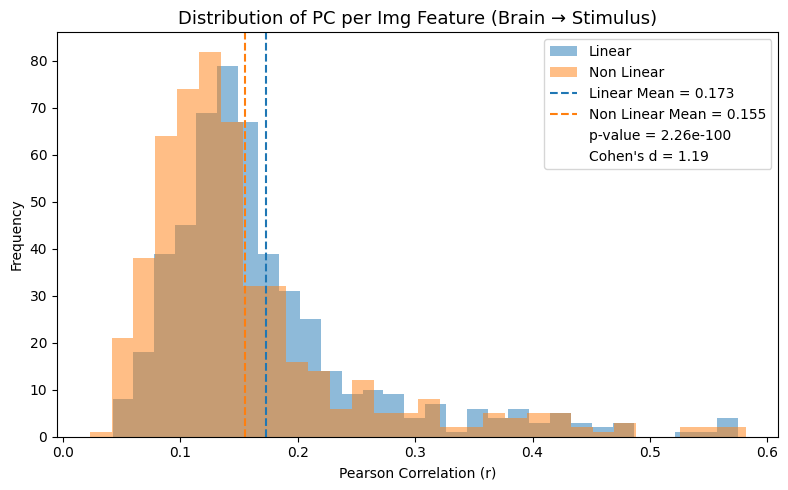

In [ ]:
from scipy.stats import ttest_rel
from matplotlib.lines import Line2D

# y_true = y_true.cpu().numpy()
y_pred_linear = y_pred.cpu().numpy()

def get_corrs(y_true, y_pred):
    return [np.corrcoef(y_true[:, i], y_pred[:, i])[0, 1] for i in range(y_true.shape[1])]

corr_linear = get_corrs(y_true, y_pred_linear)
corr_mlp = get_corrs(y_true, y_pred_mlp)

mean_linear = np.mean(corr_linear)
mean_mlp = np.mean(corr_mlp)

t_stat, p_val = ttest_rel(corr_linear, corr_mlp, alternative='greater')
print(f"Paired t-test: t = {t_stat}, p = {p_val}")

diff = np.array(corr_linear) - np.array(corr_mlp)
cohens_d = diff.mean() / diff.std()
print(f"Cohen's d: {cohens_d:.3f}")

plt.figure(figsize=(8, 5))
plt.hist(corr_linear, bins=30, alpha=0.5, label='Linear', color='tab:blue')
plt.hist(corr_mlp, bins=30, alpha=0.5, label='Non Linear', color='tab:orange')
plt.axvline(mean_linear, color='tab:blue', linestyle='--', label=f'Linear Mean = {mean_linear:.3f}')
plt.axvline(mean_mlp, color='tab:orange', linestyle='--', label=f'Non Linear Mean = {mean_mlp:.3f}')

plt.title("Distribution of PC per Img Feature (Brain → Stimulus)", fontsize=13)
plt.xlabel("Pearson Correlation (r)")
plt.ylabel("Frequency")

stat_legend = [
    Line2D([0], [0], color='none', label=f'p-value = {p_val:.2e}'),
    Line2D([0], [0], color='none', label=f"Cohen's d = {cohens_d:.2f}")
]

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles + stat_legend, labels + [h.get_label() for h in stat_legend])

plt.grid(False)
plt.tight_layout()
plt.show()


### Sim Matrix

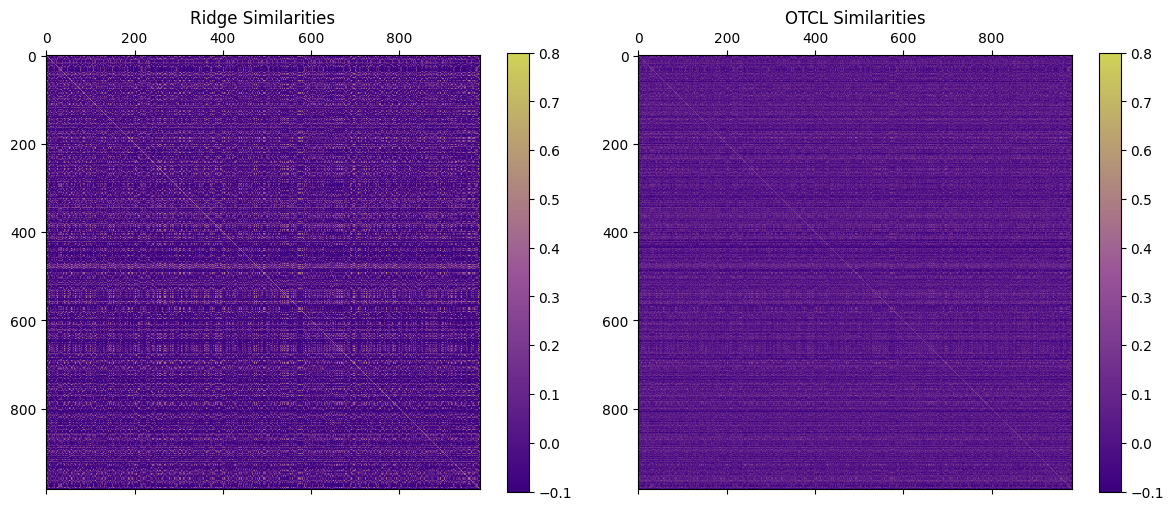

In [30]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

neuroposter_cmap = LinearSegmentedColormap.from_list('Neuroposter', (
    # Edit this gradient at https://eltos.github.io/gradient/#Neuroposter=3C0080-9A5598-CFD357
    (0.000, (0.235, 0.000, 0.502)),
    (0.500, (0.604, 0.333, 0.596)),
    (1.000, (0.812, 0.827, 0.341))))

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

im1 = axs[0].matshow(sims_ridge_subj, cmap=neuroposter_cmap, vmin=-0.1, vmax=0.8)
axs[0].set_title('Ridge Similarities')
fig.colorbar(im1, ax=axs[0])

im2 = axs[1].matshow(sims_otcl_subj, cmap=neuroposter_cmap, vmin=-0.1, vmax=0.8)
axs[1].set_title('OTCL Similarities')
fig.colorbar(im2, ax=axs[1])

plt.tight_layout()
plt.grid(False)
plt.show()

In [47]:
# Softmax
import torch
import torch.nn.functional as F

sims_ridge_soft = F.softmax(torch.tensor(sims_ridge_subj)/0.01, dim=1)
sims_otcl_soft = F.softmax(torch.tensor(sims_otcl_subj)/0.01, dim=1)




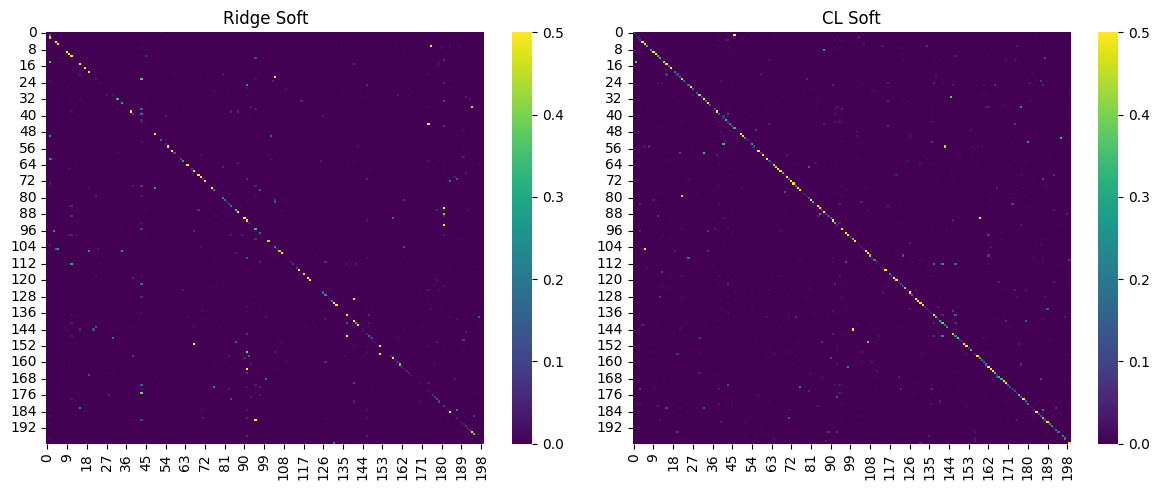

In [54]:
import matplotlib.pyplot as plt

cmap = 'viridis'
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 riga, 2 colonne
subset = slice(400, 600)

sns.heatmap(sims_ridge_soft[subset, subset], cmap=cmap, vmin=0, vmax=0.5, ax=axes[0])
axes[0].set_title("Ridge Soft")
sns.heatmap(sims_otcl_soft[subset, subset], cmap=cmap, vmin=0, vmax=0.5, ax=axes[1])
axes[1].set_title("CL Soft")

plt.tight_layout()
plt.show()


In [129]:
diagonal_values_otcl = np.diag(sims_otcl_subj)
off_diagonal_values_otcl = sims_otcl_subj[~np.eye(sims_otcl_subj.shape[0], dtype=bool)]

mean_diag_otcl = diagonal_values_otcl.mean()
std_diag_otcl  = diagonal_values_otcl.std()
mean_off_otcl  = off_diagonal_values_otcl.mean()
std_off_otcl   = off_diagonal_values_otcl.std()

print("\nStatistiche Diagonale:")
print(f"Media  = {mean_diag_otcl:.4f}")
print(f"Dev Std= {std_diag_otcl:.4f}")

print("\nStatistiche Fuori Diagonale:")
print(f"Media  = {mean_off_otcl:.4f}")
print(f"Dev Std= {std_off_otcl:.4f}")


Statistiche Diagonale:
Media  = 0.1987
Dev Std= 0.0529

Statistiche Fuori Diagonale:
Media  = 0.0390
Dev Std= 0.0628


In [130]:
diagonal_values_ridge = np.diag(sims_ridge_subj)
off_diagonal_values_ridge = sims_ridge_subj[~np.eye(sims_ridge_subj.shape[0], dtype=bool)]

mean_diag_ridge = diagonal_values_ridge.mean()
std_diag_ridge  = diagonal_values_ridge.std()
mean_off_ridge  = off_diagonal_values_ridge.mean()
std_off_ridge   = off_diagonal_values_ridge.std()

print("\nStatistiche Diagonale:")
print(f"Media  = {mean_diag_ridge:.4f}")
print(f"Dev Std= {std_diag_ridge:.4f}")

print("\nStatistiche Fuori Diagonale:")
print(f"Media  = {mean_off_ridge:.4f}")
print(f"Dev Std= {std_off_ridge:.4f}")


Statistiche Diagonale:
Media  = 0.3398
Dev Std= 0.1111

Statistiche Fuori Diagonale:
Media  = 0.0102
Dev Std= 0.1451
